In [296]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

#data analysis libs
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind, wilcoxon, f_oneway
from matplotlib import pyplot as plt, ticker
from statannot import add_stat_annotation
from tqdm import tqdm
import seaborn as sns
sns.set_theme(font_scale=1.8)

#bioinf libs
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting
import pyranges as pr
import gffpandas.gffpandas as gffpd
import gseapy
from gseapy import barplot, dotplot

#common libs
from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
from natsort import natsorted, natsort_keygen
import pickle
import logging
logging.getLogger().disabled = True

#my stuff
import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [211]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
MERGED_COOLER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_coolers'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
MERGED_DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'
EXPRESSION_PATH = '/tank/projects/kriukov_chromatin/RNA'

In [212]:
#import genes
gffpath = '%s/Mus_musculus.GRCm38.102.chr.gff3' % GENOME_FOLDER_PATH
annotation = gffpd.read_gff3(gffpath)
#annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
#fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
#refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
#gn.seq_id = gn.seq_id.map(refseq2chrom)
gn.seq_id = 'chr' + gn.seq_id.astype('str')
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length']]
gn['Name'] = gn['Name'].str.upper()
#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/gffpandas/gffpandas.py:21: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  self._read_gff3_to_df()


In [308]:
RESOLUTION = 50_000
downsampled = True
merged = True

if downsampled:
    if merged:
        FILES = natsorted(glob('%s/*2000.mcool' % (MERGED_DOWNSAMPLED_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = [basename(c.filename).split('_')[0] for c in CLRS]
    else:
        FILES = natsorted(glob('%s/*2000.mcool' % (DOWNSAMPLED_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = ['_'.join(basename(c.filename).split('_')[:3]) for c in CLRS]
else:
    if merged:
        FILES = natsorted(glob('%s/*.mcool' % (MERGED_COOLER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = [basename(c.filename).split('.')[0] for c in CLRS]
    else:
        FILES = natsorted(glob('%s/*.mcool' % (COOLER_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = ['_'.join(basename(c.filename).split('_')[:3]).split('.')[0] for c in CLRS]

[print(c, '\t', l) for c, l in zip(CLRS, LBLS)];

#compartments
if merged:
    eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/*_down_no_2_diag_50000*lam.txt'))
    eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/*_down_no_2_diag_50000*vecs.txt'))
    eigvec = {l:pd.read_csv(f, sep='\t') \
              for l, f in zip(['KO', 'adl', 'old', 'yng'], eigvec_files)}
    eigval = {l:pd.read_csv(f, sep='\t', index_col=1) \
                for l, f in zip(['KO', 'adl', 'old', 'yng'], eigval_files)}
else:
    eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/*lam.txt'))
    eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/*vecs.txt'))
    eigvec = {l:pd.read_csv(f, sep='\t') \
              for l, f in zip(['KO', 'adl', 'old', 'yng'], eigvec_files)}
    eigval = {l:pd.read_csv(f, sep='\t', index_col=1) \
                for l, f in zip(['KO', 'adl', 'old', 'yng'], eigval_files)}

#insulation score
if merged:
    IS = pd.read_csv('%s/IS_merged_new_50000.csv' % INSULATION_PATH, index_col=0)
else:
    #IS = pd.read_csv('%s/IS_25000.csv' % INSULATION_PATH, index_col=0)
    IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
TADS = json.load(open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r'))

#diffexpressed genes
slopes = pd.read_csv('subdata/diffexp_result.csv', index_col=0)
pbulk_full = pd.read_csv('subdata/DE_results_GSE129788_old::young.csv', index_col=0)
pbulk_neur = pd.read_csv('subdata/DE_results_GSE129788_old::young_mNeur.csv', index_col=0)
sc_neur =  pd.read_csv('subdata/scDE_results_GSE129788_old::young.csv', index_col=0)
sc_neur['gene'] = sc_neur['gene'].str.upper()

#gene sets
gene_sets = json.load(open('subdata/genesets/age_gene_set.gmt', 'r'))

#List of neuron specific genes
min_gene_length = 0
de_genes = sc_neur[(sc_neur.qval < 1e-3)]
sc_neur_filt = sc_neur.merge(gn_code[['Name', 'seq_id', 'start', 'end']], left_on='gene', right_on='Name')
#size filter
universe_neur_list = sc_neur_filt[sc_neur_filt['mean'] >= de_genes['mean'].min()].gene.tolist()
universe_neur_list = list(map(str.upper, universe_neur_list))
print('Universe size:', len(universe_neur_list))


#snp profiles 
snp_profiles = pd.read_csv('subdata/snp_profiles.csv', index_col=0)
snp_merged = snp_profiles.copy()
snp_merged['adl'] = snp_profiles.filter(regex='WT').sum(1)
snp_merged['yng'] = snp_profiles.filter(regex='young').sum(1)
snp_merged['old'] = snp_profiles.filter(regex='old').sum(1)
snp_merged = snp_merged[['chrom', 'start', 'yng', 'adl', 'old']]

#view and chromsizes
mm10_arms = pd.read_csv('subdata/mm10_view.bed', sep='\t', names=['chrom', 'start', 'end', 'name'])
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
mm10_chromsizes = CLRS[0].chromsizes

#construct scalings
scalings_data = {}
trans_data = {}
ignore_diags = 2
for cond, clr in zip(LBLS, CLRS):
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=None,
                            chunksize=1000000, nproc=18,
                            smooth=True, aggregate_smoothed=True, 
                            smooth_sigma=0.1,
                            ignore_diags=ignore_diags)
    trans = expected_trans(clr, view_df=None,
                           chunksize=1000000, nproc=18,
                           # full chromosomes as the view
                            )
    scalings_data[cond] = expected
    trans_data[cond] = trans

<Cooler "KO_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 KO
<Cooler "adl_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 adl
<Cooler "old_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 old
<Cooler "yng_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 yng


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Universe size: 11251


In [309]:
#arguments
genes = gn_code.sample(10, random_state=330)
# genes = gn_code[gn_code['Name'].isin(['ADCY5', 'HTT', 'AKT1', 'AKT2', 'CDKN1A'])]
print(genes['length'].mean())
genes = genes.sort_values('seq_id', key=natsort_keygen())
genes

18263.1


,seq_id,source,type,start,end,score,strand,ID,Name,description,length
36042,chr1,havana,gene,36710149,36757953,.,+,gene:ENSMUSG00000102416,4933424G06RIK,RIKEN cDNA 4933424G06 gene [Source:MGI Symbol%...,47804
2020262,chr2,ensembl_havana,gene,89991221,89996189,.,+,gene:ENSMUSG00000061295,OLFR1261,olfactory receptor 1261 [Source:MGI Symbol%3BA...,4968
2042583,chr2,ensembl_havana,gene,104027721,104063240,.,+,gene:ENSMUSG00000027180,FBXO3,F-box protein 3 [Source:MGI Symbol%3BAcc:MGI:1...,35519
2703758,chr5,havana,gene,65405751,65406517,.,+,gene:ENSMUSG00000106291,1110003F10RIK,RIKEN cDNA 1110003F10 gene [Source:MGI Symbol%...,766
2923103,chr6,ensembl_havana,gene,48718621,48724636,.,+,gene:ENSMUSG00000043931,GIMAP7,GTPase%2C IMAP family member 7 [Source:MGI Sym...,6015
539336,chr11,ensembl_havana,gene,60469339,60528369,.,+,gene:ENSMUSG00000042678,MYO15,myosin XV [Source:MGI Symbol%3BAcc:MGI:1261811],59030
564509,chr11,ensembl_havana,gene,70054085,70057894,.,+,gene:ENSMUSG00000020884,ASGR1,asialoglycoprotein receptor 1 [Source:MGI Symb...,3809
567542,chr11,ensembl_havana,gene,70651850,70654644,.,-,gene:ENSMUSG00000018293,PFN1,profilin 1 [Source:MGI Symbol%3BAcc:MGI:97549],2794
920114,chr13,ensembl_havana,gene,50417864,50433780,.,+,gene:ENSMUSG00000037816,FBXW17,F-box and WD-40 domain protein 17 [Source:MGI ...,15916
1562129,chr17,ensembl_havana,gene,35910379,35916389,.,-,gene:ENSMUSG00000024436,MRPS18B,mitochondrial ribosomal protein S18B [Source:M...,6010


In [310]:
def get_gene_pixels(clr, genes,
                    cis_exp=None,
                    trans_exp=None,
                    balance=False, 
                    ignore_diags=2,
                    return_type='genes'): #may be gene list to input is better (not dataframe)
    """
    Function returns submatrix of Hi-C matrix with pixels 
    corresponding only the genes in the given list.
    """
    expected_column = 'count.avg' if balance else 'balanced.avg'
    bins = clr.bins()[:].iloc[:, :3]
    gb = bins_to_genes_intersection(bins, genes)
    gb = bins.reset_index().merge(gb, 
                             left_on=['chrom', 'start', 'end'], 
                             right_on=['Chromosome', 'Start_b', 'End_b'])
    idx = gb['index'].copy().tolist()
    chroms = gb['chrom'].tolist()
    clmat = clr.matrix(balance=balance)
    mat = np.zeros((len(idx), len(idx)))
    for i, (ix1, chr1) in enumerate(zip(idx, chroms)):
        #for j, (ix2, chr2) in enumerate(zip(idx, chroms)):
        for j, (ix2, chr2) in enumerate(zip(idx[i:], chroms[i:]), start=i):
            dist = abs(i - j)
            if dist < ignore_diags:
                mat[i, j] = 0
            else:
                if chr1 == chr2: 
                    #cis contact
                    if (cis_exp is not None) and (trans_exp is not None):
                        coef = cis_exp[(cis_exp['region1']==chr1) & 
                                       (cis_exp['dist']==dist)][expected_column].item()
                    else: 
                        coef = 1
                    mat[i, j] = clmat[ix1, ix2] / coef
                    mat[j, i] = clmat[ix1, ix2] / coef
                else: 
                    #trans contact
                    if (cis_exp is not None) and (trans_exp is not None):
                        coef = trans_exp[(trans_exp['region1']==chr1) & 
                                         (trans_exp['region2']==chr2)][expected_column].item()
                    else:
                        coef = 1
                    mat[i, j] = clmat[ix1, ix2] / coef
                    mat[j, i] = clmat[ix1, ix2] / coef
    if return_type=='genes':
        mat = pd.DataFrame(mat, index=gb['Name'], columns=gb['Name'])
    elif return_type=='intervals':
        pass
    return mat

In [314]:
genes

,seq_id,source,type,start,end,score,strand,ID,Name,description,length
36042,chr1,havana,gene,36710149,36757953,.,+,gene:ENSMUSG00000102416,4933424G06RIK,RIKEN cDNA 4933424G06 gene [Source:MGI Symbol%...,47804
2020262,chr2,ensembl_havana,gene,89991221,89996189,.,+,gene:ENSMUSG00000061295,OLFR1261,olfactory receptor 1261 [Source:MGI Symbol%3BA...,4968
2042583,chr2,ensembl_havana,gene,104027721,104063240,.,+,gene:ENSMUSG00000027180,FBXO3,F-box protein 3 [Source:MGI Symbol%3BAcc:MGI:1...,35519
2703758,chr5,havana,gene,65405751,65406517,.,+,gene:ENSMUSG00000106291,1110003F10RIK,RIKEN cDNA 1110003F10 gene [Source:MGI Symbol%...,766
2923103,chr6,ensembl_havana,gene,48718621,48724636,.,+,gene:ENSMUSG00000043931,GIMAP7,GTPase%2C IMAP family member 7 [Source:MGI Sym...,6015
539336,chr11,ensembl_havana,gene,60469339,60528369,.,+,gene:ENSMUSG00000042678,MYO15,myosin XV [Source:MGI Symbol%3BAcc:MGI:1261811],59030
564509,chr11,ensembl_havana,gene,70054085,70057894,.,+,gene:ENSMUSG00000020884,ASGR1,asialoglycoprotein receptor 1 [Source:MGI Symb...,3809
567542,chr11,ensembl_havana,gene,70651850,70654644,.,-,gene:ENSMUSG00000018293,PFN1,profilin 1 [Source:MGI Symbol%3BAcc:MGI:97549],2794
920114,chr13,ensembl_havana,gene,50417864,50433780,.,+,gene:ENSMUSG00000037816,FBXW17,F-box and WD-40 domain protein 17 [Source:MGI ...,15916
1562129,chr17,ensembl_havana,gene,35910379,35916389,.,-,gene:ENSMUSG00000024436,MRPS18B,mitochondrial ribosomal protein S18B [Source:M...,6010


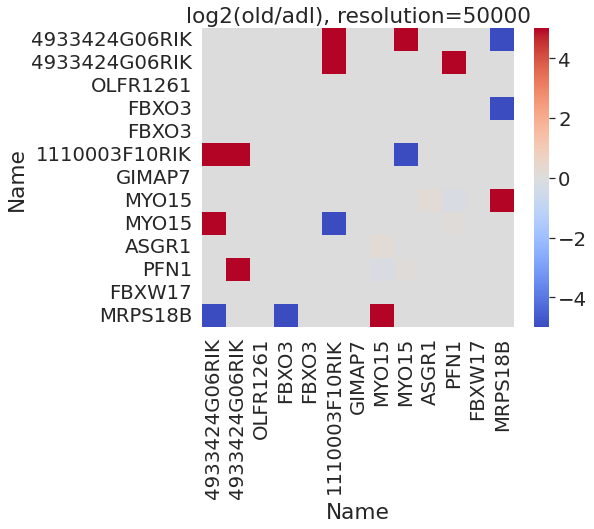

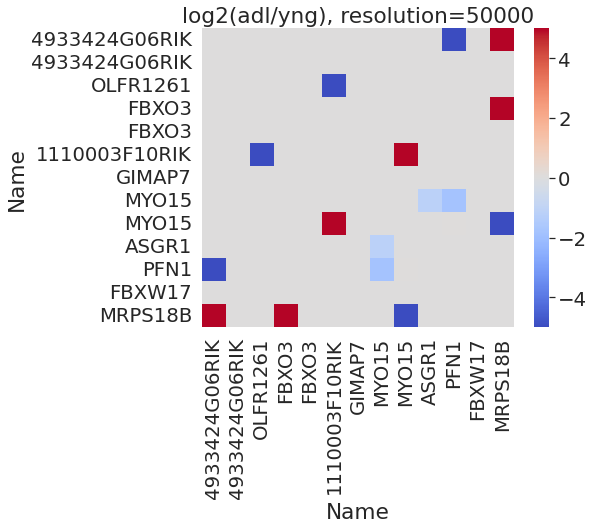

In [315]:
eps = 1#1e-6
balance = False

for clr1, clr2, pair in [[CLRS[1], CLRS[2], ('old', 'adl')], 
                         [CLRS[3], CLRS[1], ('adl', 'yng')]]:
    mat1 = get_gene_pixels(clr1, genes, 
                           cis_exp=scalings_data[pair[1]], 
                           trans_exp=trans_data[pair[1]], 
                           balance=balance)
    mat2 = get_gene_pixels(clr2, genes, 
                           cis_exp=scalings_data[pair[0]], 
                           trans_exp=trans_data[pair[0]], 
                           balance=balance)
    div = np.log2((mat2 + eps) / (mat1 + eps))

    #plotting
    fig, ax = plt.subplots(1,1, figsize=(7,5.5))
    sns.heatmap(div, xticklabels=True, yticklabels=True, vmin=-5, vmax=5, cmap='coolwarm', ax=ax)
    ax.set_title(f'log2({pair[0]}/{pair[1]}), resolution={RESOLUTION}')
    plt.show()

In [313]:
div

Name,4933424G06RIK,4933424G06RIK,OLFR1261,FBXO3,FBXO3,1110003F10RIK,GIMAP7,MYO15,MYO15,ASGR1,PFN1,FBXW17,MRPS18B
Name,,,,,,,,,,,,,
4933424G06RIK,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-18.270191,0.0,17.637469
4933424G06RIK,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
OLFR1261,0.000000,0.0,0.000000,0.000000,0.0,-17.409762,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
FBXO3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.228593
FBXO3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1110003F10RIK,0.000000,0.0,-17.409762,0.000000,0.0,0.000000,0.0,0.000000,16.897458,0.000000,0.000000,0.0,0.000000
GIMAP7,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
MYO15,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,-1.164464,-1.820080,0.0,0.000000
MYO15,0.000000,0.0,0.000000,0.000000,0.0,16.897458,0.0,0.000000,0.000000,0.000000,0.049895,0.0,-16.882454
